In [17]:
import os
import re
import unicodedata
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, f1_score, classification_report

from transformers import AutoTokenizer, AutoModel
from pythainlp.tokenize import word_tokenize

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import coalesce  

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import networkx as nx


In [18]:
import sys
sys.executable


'c:\\Users\\Infinix\\Documents\\GitHub\\Project_Thaifakenews\\.venv\\Scripts\\python.exe'

part Import 

pip install --quiet transformers
pip install torch
pip install pandas
pip install pythainlp


Classes: {'ข่าวจริง': 0, 'ข่าวปลอม': 1}

In [19]:
# =========================
# Load & clean data
# =========================
#df = pd.read_csv('AFNC_Opendata_export_20251212163506(AutoRecovered)_Sheet1.csv')



In [20]:
# =========================
# Load & clean data
# =========================
df = pd.read_csv('AFNC_news_dataset_tf.csv')



In [21]:
# กำหนด mapping dictionary
label_map = {
    'ข่าวจริง': 'true',
    'ข่าวปลอม': 'fake',
}

In [22]:
# import pandas as pd

# # 1. โหลดไฟล์ CSV (เปลี่ยนชื่อไฟล์ 'news_data.csv' เป็นชื่อไฟล์จริงของคุณ)
# # encoding='utf-8' หรือ 'utf-8-sig' สำคัญมากสำหรับภาษาไทย
# df = pd.read_csv('AFNC_news_dataset_tf.csv', encoding='utf-8')

# # --- ตรวจสอบจำนวนก่อนลบ ---
# print("จำนวนแถวทั้งหมดก่อนลบ:", len(df))
# print("จำนวนข่าว Fake ก่อนลบ:", len(df[df['label_binary'] == 'fake']))
# print("-" * 30)

# # 2. หา Index (เลขบรรทัด) ของข้อมูลที่เป็น 'fake' ทั้งหมด
# fake_indices = df[df['label_binary'] == 'fake'].index

# # 3. ตรวจสอบว่ามีข่าวปลอมพอให้ลบไหม (ต้องมากกว่าหรือเท่ากับ 3000)
# amount_to_remove = 3000

# if len(fake_indices) >= amount_to_remove:
#     # 4. สุ่มเลือก Index มา 3000 ตัว (random_state=42 เพื่อให้ผลเหมือนเดิมทุกครั้งที่รัน)
#     indices_to_drop = pd.Series(fake_indices).sample(n=amount_to_remove, random_state=42)
    
#     # 5. สั่งลบแถวเหล่านั้นออกจากตารางหลัก
#     df_new = df.drop(indices_to_drop)
    
#     # --- ตรวจสอบผลลัพธ์ ---
#     print(f"ลบข่าวปลอมออกไปแล้ว {amount_to_remove} แถว")
#     print("จำนวนแถวที่เหลือ:", len(df_new))
#     print("จำนวนข่าว Fake ที่เหลือ:", len(df_new[df_new['label_binary'] == 'fake']))
    
#     # 6. บันทึกเป็นไฟล์ใหม่ (แนะนำให้ตั้งชื่อใหม่กันไฟล์เดิมหาย)
#     df_new.to_csv('news_data_cleaned.csv', index=False, encoding='utf-8-sig')
#     print("บันทึกไฟล์ใหม่ชื่อ 'news_data_cleaned.csv' เรียบร้อยแล้ว")
    
# else:
#     print(f"ไม่สามารถลบได้: มีข่าวปลอมเพียง {len(fake_indices)} แถว (ต้องการลบ {amount_to_remove})")

In [23]:
# ทำความสะอาด label ลบอิโมจิ และแมปค่า 
# Normalization Function

#ลบ

# Remove zero-width characters  
ZW = ''.join(['\u200B', '\u200C', '\u200D', '\uFEFF'])


def normalize_thai(s):
    if pd.isna(s):
        return None
    #non-breaking space
    s = str(s).replace('\u00A0', ' ').translate({ord(ch): None for ch in ZW})
    s = unicodedata.normalize('NFC', s)
    s = re.sub(r'\s+', ' ', s).strip()
    # collapse repeated diacritics/marks
    s = re.sub(r'([\u0E31\u0E34-\u0E3A\u0E47-\u0E4E])\1+', r'\1', s)
    return s

df['ประเภทข่าว'] = df['ประเภทข่าว'].apply(normalize_thai) #print
df['หมวดหมู่ของข่าว'] = df['หมวดหมู่ของข่าว'].apply(normalize_thai)


In [24]:
# # สร้างคอลัมน์ใหม่ 'label_binary' เป็น binary label จาก mapping
df['label_binary'] = df['ประเภทข่าว'].map(label_map)

# # ลบแถวที่เป็น None (ข่าวอื่นๆ)
#df = df.dropna(subset=['label_binary'])

# # ถ้าต้องการ save เป็น CSV ใหม่
#df.to_csv('AFNC_news_dataset_tf.csv', index=False)
#df.to_excel('news_dataset_truefakenews.xlsx', index=False)


# ดูผลลัพธ์
print(df[['หัวข้อข่าว','หมวดหมู่ของข่าว']].head(10))


                                          หัวข้อข่าว       หมวดหมู่ของข่าว
0         ทหารกัมพูชา วางอาวุธและยกมือแสดงการยอมจำนน  ความสงบและความมั่นคง
1  ประกาศเคอร์ฟิว ห้ามประชาชนในพื้นที่ชายแดนไทย-ก...  ความสงบและความมั่นคง
2  หลีกเลี่ยงการใช้เส้นทางหมายเลข 348 แก้วเพชรพลอ...  ความสงบและความมั่นคง
3   กองทัพไทย ทำลายบ่อนคาสิโนที่บัญชาการรบของกัมพูชา  ความสงบและความมั่นคง
4  กทม. ประกาศเข้ม ห้ามจุดพลุ–โคมลอย ช่วงเทศกาลปี...  นโยบายรัฐบาล-ข่าวสาร
5  เปิดวิธียืนยันตัวตนที่ตู้กรุงไทย ATM คนละครึ่ง...  นโยบายรัฐบาล-ข่าวสาร
6  ไทยเป็นฝ่ายเริ่มรุกราน และใช้อาวุธทุกชนิดโจมตี...  ความสงบและความมั่นคง
7  กกท. ยังไม่ชำระค่าเช่าสนามเปตอง 400,000 บาท จึ...  นโยบายรัฐบาล-ข่าวสาร
8  สั่งการ 3 มาตรการเร่งด่วน รับสถานการณ์ชายแดนไท...  ความสงบและความมั่นคง
9           ไทยใช้ควันพิษพ่นใส่ทหารกัมพูชาที่ภูเขาผี  ความสงบและความมั่นคง


In [25]:
# โหลดโมเดลภาษาไทย + จัด device WangchanBERTa
model_WCB = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_WCB, use_fast=False)
#WangchanBERTa
lm_model = AutoModel.from_pretrained(model_WCB)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#ย้ายไปdevice    
lm_model = lm_model.to(device).eval()


In [26]:
#กำหนดและคงค่าความสัมพันธ์ระหว่าง label กับตัวเลข   ข่าวจริง: 0, ข่าวปลอม: 1
#  Mapping จาก label → ตัวเลข
label2id = {'ข่าวจริง': 0, 'ข่าวปลอม': 1}
# Mapping จากตัวเลข → label
id2label = {v: k for k, v in label2id.items()}

Dataset Size: 11035 | ข่าวจริง: 2796, ข่าวปลอม: 8237


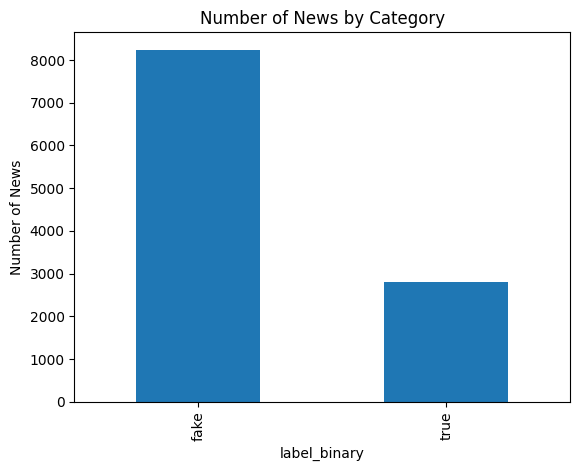

In [27]:
# สรุปข้อมูลเบื้องต้นของจำนวนข่าวในแต่ละคลาส
num_true = (df['label_binary'] == 'true').sum()
num_fake = (df['label_binary'] == 'fake').sum()
print(f"Dataset Size: {len(df)} | ข่าวจริง: {num_true}, ข่าวปลอม: {num_fake}")

# กราฟแท่งแสดงจำนวนข่าวในแต่ละคลาส
try:
    df['label_binary'].value_counts().plot(kind='bar')
    plt.title('Number of News by Category')
    plt.ylabel('Number of News')
    plt.show()
except Exception as e:
    print("Plot skipped:", e)



# ✅ ใช้ raw text ตรง ๆ สำหรับ BERT embedding
#titles = df['title'].tolist()
contents = df['หัวข้อข่าว'].tolist()

In [28]:
# ดูตัวอย่าง content (raw text)
print("\nSample of content:")
print(df[['หัวข้อข่าว']].head(1))

# ถ้าต้องการสถิติ token length จาก BERT tokenizer
encoded_inputs = tokenizer(
    df['หัวข้อข่าว'].tolist(),
    padding=False,
    truncation=False,
    return_tensors=None
)

token_lengths = [len(tokens) for tokens in encoded_inputs['input_ids']]
print("\nToken statistics (from WangchanBERTa tokenizer):")
print(f"Average tokens in หัวข้อข่าว: {sum(token_lengths)/len(token_lengths):.2f}")

#--- TRUE NEWS SAMPLES ---
print("\nSample of true news content:")
print(df[df['label_binary'] == 'true'][['หัวข้อข่าว', 'label_binary']].head(2))

#--- FAKE NEWS SAMPLES ---
print("\nSample of fake news content:")
print(df[df['label_binary'] == 'fake'][['หัวข้อข่าว', 'label_binary']].head(2))



Sample of content:
                                   หัวข้อข่าว
0  ทหารกัมพูชา วางอาวุธและยกมือแสดงการยอมจำนน

Token statistics (from WangchanBERTa tokenizer):
Average tokens in หัวข้อข่าว: 20.79

Sample of true news content:
                                          หัวข้อข่าว label_binary
1  ประกาศเคอร์ฟิว ห้ามประชาชนในพื้นที่ชายแดนไทย-ก...         true
2  หลีกเลี่ยงการใช้เส้นทางหมายเลข 348 แก้วเพชรพลอ...         true

Sample of fake news content:
                                          หัวข้อข่าว label_binary
0         ทหารกัมพูชา วางอาวุธและยกมือแสดงการยอมจำนน         fake
5  เปิดวิธียืนยันตัวตนที่ตู้กรุงไทย ATM คนละครึ่ง...         fake


In [29]:
# -------------------------------------------
# ฟังก์ชันสร้าง BERT Embedding WangchanBERT
# -------------------------------------------
#Decorator 
@torch.no_grad()
def get_bert_embeddings_batch(
    texts,
    tokenizer,
    model,
    device,
    max_length=256,
    batch_size=32,
    use_mean_pool=True,
):
    """
    สร้าง BERT embeddings แบบ batch สำหรับลิสต์ของข้อความ (texts)
    คืนค่าเป็น numpy array รูป (N, hidden_size)
    """
    model.eval()  # ให้แน่ใจว่าอยู่ในโหมด eval

    all_embeddings = []

    # loop ทีละ batch
    for start_idx in range(0, len(texts), batch_size):
        batch_texts = texts[start_idx:start_idx + batch_size]

        # กัน NaN / non-string
        batch_texts = [
            "" if (isinstance(t, float) and np.isnan(t)) else str(t)
            for t in batch_texts
        ]

        # Tokenize ทั้ง batch
        inputs = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,          # padding ตาม batch
            max_length=max_length,
            return_tensors='pt'
        ).to(device)

        outputs = model(**inputs)
        last_hidden = outputs.last_hidden_state   # (B, seq_len, hidden)

        if use_mean_pool:
            # mean pooling ตาม attention mask
            attn = inputs['attention_mask'].unsqueeze(-1)      # (B, seq_len, 1)
            summed = (last_hidden * attn).sum(dim=1)           # (B, hidden)
            denom = attn.sum(dim=1).clamp(min=1)               # (B, 1)
            emb = (summed / denom).cpu().numpy()               # (B, hidden)
        else:
            # ใช้ CLS token
            emb = last_hidden[:, 0, :].cpu().numpy()           # (B, hidden)

        all_embeddings.append(emb)

    # รวมทุก batch เข้าด้วยกัน
    return np.vstack(all_embeddings)   # (N, hidden_size)


tensor

In [30]:
# from imblearn.over_sampling import RandomOverSampler
# from sklearn.preprocessing import normalize # ต้องนำเข้าหากยังไม่ได้ทำ

In [31]:
# -------------------------------------------
# เตรียม DataFrame ก่อนทำ BERT
# -------------------------------------------

# กรองแถวที่ไม่มี content / label / category ทิ้ง
df = df.dropna(subset=['หัวข้อข่าว', 'ประเภทข่าว', 'หมวดหมู่ของข่าว']).reset_index(drop=True)

# --- 1) mapping สำหรับข่าวจริง/ข่าวปลอม ---
label2id = {
    'ข่าวจริง': 0,
    'ข่าวปลอม': 1,
}
id2label = {v: k for k, v in label2id.items()}

# กรองให้เหลือเฉพาะ label ที่เรารู้จัก
df = df[df['ประเภทข่าว'].isin(label2id.keys())].reset_index(drop=True)

df['label_id'] = df['ประเภทข่าว'].map(label2id)

# --- 2) mapping สำหรับ category ---
unique_cats = sorted(df['หมวดหมู่ของข่าว'].dropna().unique())
cat2id = {c: i for i, c in enumerate(unique_cats)}
id2cat = {i: c for c, i in cat2id.items()}

df['category_id'] = df['หมวดหมู่ของข่าว'].map(cat2id).astype(int)

# -------------------------------------------
# สร้าง BERT embedding จาก content 
# -------------------------------------------

# ถ้าใช้เฉพาะ content
texts = df['หัวข้อข่าว'].fillna("").astype(str).tolist()

print("\nCreating BERT Embeddings for Content (batch)...")
content_emb = get_bert_embeddings_batch(
    texts,
    tokenizer=tokenizer,
    model=lm_model,
    device=device,
    max_length=256,
    batch_size=32,
    use_mean_pool=True,
)

print("content_emb shape:", content_emb.shape)  # เช่น (N, 768) สำหรับ WangchanBERT base

# ปกติใช้ L2 normalize ให้เวกเตอร์ยาวเท่ากัน
x_np = normalize(content_emb, axis=1, norm='l2')

# target สำหรับ fake/real
y_np = df['label_id'].values

# target สำหรับ category
y_cat_np = df['category_id'].values

print("x_np shape (ก่อน oversampling):", x_np.shape)
print("y_np shape (ก่อน oversampling):", y_np.shape)
print(f"จำนวนตัวอย่างก่อน oversampling (fake/real): {np.unique(y_np, return_counts=True)}")




Creating BERT Embeddings for Content (batch)...
content_emb shape: (11033, 768)
x_np shape (ก่อน oversampling): (11033, 768)
y_np shape (ก่อน oversampling): (11033,)
จำนวนตัวอย่างก่อน oversampling (fake/real): (array([0, 1]), array([2796, 8237]))


In [32]:
# 1. --- คำนวณ Class Weight (หัวใจสำคัญของการแก้ Imbalance) ---
# นับจำนวนข่าวจากคอลัมน์ label_id (0=ข่าวจริง, 1=ข่าวปลอม)
num_real = (df['label_id'] == 0).sum()
num_fake = (df['label_id'] == 1).sum()

print(f"📊 Stats: ข่าวจริง (Real) = {num_real} | ข่าวปลอม (Fake) = {num_fake}")

# คำนวณ Weight: ให้คลาสที่มีน้อยมีค่าความสำคัญมาก (Inverse Frequency)
max_count = max(num_real, num_fake)
w_real = max_count / num_real  # เช่น 8237/2796 ≈ 2.94
w_fake = max_count / num_fake  # เช่น 8237/8237 = 1.0

# สร้าง Tensor Weight (ระวัง! ต้องเรียงลำดับ index 0, 1 ให้ตรงกับ label)
# สมมติ: 0=Real, 1=Fake
class_weights = torch.tensor([w_real, w_fake], dtype=torch.float32).to(device)

# สร้าง Loss Function รอไว้เลย
criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"⚖️ Class Weights Applied: Real={w_real:.4f}, Fake={w_fake:.4f}")
print("✅ Loss Function (criterion) is ready to use.")

📊 Stats: ข่าวจริง (Real) = 2796 | ข่าวปลอม (Fake) = 8237
⚖️ Class Weights Applied: Real=2.9460, Fake=1.0000
✅ Loss Function (criterion) is ready to use.


หน้าตาเป็นไง ใช้สูตรอะไร ยังไม่ได้กำหนด cate mapping num

In [33]:
# ดูตัวอย่าง DataFrame ของ Embedding
pd.DataFrame(x_np).head()

print(x_np.shape)   # ดูขนาด เช่น (จำนวนเอกสาร, ขนาดเวกเตอร์)
print(x_np[0])      # ดู embedding ของตัวอย่างแรก


(11033, 768)
[ 7.89084733e-02  1.57405864e-02 -5.60529297e-04  2.57756300e-02
  1.38346823e-02  6.30716700e-03  2.99287960e-02  3.55136134e-02
  1.12820268e-02  6.26613433e-03  2.06602551e-02  2.67058276e-02
  1.98694039e-02 -2.69870982e-02 -1.39484247e-02 -4.35553025e-03
  1.85126029e-02 -2.53709196e-03  1.17044961e-02  4.42126170e-02
  4.00679782e-02  8.83241743e-03  2.04360187e-02 -2.62410250e-02
 -8.06983840e-03  1.10674473e-02 -1.10439453e-02 -1.48408376e-02
 -4.00166512e-02 -5.56426197e-02  7.74044776e-03  1.85646173e-02
  2.54683290e-02 -3.83801088e-02  4.59307805e-02  3.99299189e-02
 -2.62889732e-02 -4.12419625e-02 -4.47125845e-02  1.24173403e-01
 -8.36326275e-03  3.71030997e-03 -3.02478857e-02  1.81774665e-02
 -1.41019924e-02 -3.64611670e-02  8.90105963e-03 -3.04615032e-02
  3.04908901e-02  2.46124007e-02 -8.29354748e-02  5.08269714e-03
  4.75928001e-03  2.48540635e-03  3.86644602e-02  8.63700453e-03
  6.68554753e-02  2.55374201e-02  7.94003811e-03 -4.19553071e-02
 -1.45920264

เสร็จ embedding //ทำไมจุดเป็นแบบนี้

In [34]:

# แปลง labels -> ตัวเลข
classes = sorted(df['ประเภทข่าว'].unique())
label2id = {c:i for i,c in enumerate(classes)}
y_np = df['ประเภทข่าว'].map(label2id).values
print(f"Classes: {label2id}")

# สร้าง mapping category → id
unique_cats = sorted(df['หมวดหมู่ของข่าว'].dropna().unique())
cat2id = {c: i for i, c in enumerate(unique_cats)}
id2cat = {i: c for c, i in cat2id.items()}

# แปลง category เป็นตัวเลข
df['category_id'] = df['หมวดหมู่ของข่าว'].map(cat2id)

# เตรียม y สำหรับ category
y_cat_np = df['category_id'].values

Classes: {'ข่าวจริง': 0, 'ข่าวปลอม': 1}


In [35]:
# ====================================================================
# kNN Graph Construction (ใช้กับ content)
# ====================================================================
k = 8
N = x_np.shape[0]  # ใช้ N เดิม (ประมาณ 11,000) ไม่มีการเพิ่มจำนวน
print(f"\n--- Building kNN Graph with k={k} ---")

# 2.1 Fit kNN
nbrs = NearestNeighbors(n_neighbors=k + 1, metric='cosine').fit(x_np)
dist, idx = nbrs.kneighbors(x_np)

# 2.2 Create edges and weights (directed)
src = np.repeat(np.arange(N), k)
dst = idx[:, 1:].reshape(-1)
w = 1.0 - dist[:, 1:].reshape(-1)

# 2.3 Make undirected (ทำให้เป็นกราฟไม่มีทิศทาง)
edge_index_np = np.vstack([src, dst])
edge_index_np_rev = edge_index_np[::-1, :]
edge_index_np = np.concatenate([edge_index_np, edge_index_np_rev], axis=1)
edge_weight_np = np.concatenate([w, w], axis=0)

# แปลงเป็น Tensor
edge_index = torch.tensor(edge_index_np, dtype=torch.long)
edge_weight = torch.tensor(edge_weight_np, dtype=torch.float)

# 2.4 Coalesce (รวมเส้นซ้ำ)
try:
    edge_index, edge_weight = coalesce(edge_index, edge_weight, N, reduce='mean')
except Exception as e:
    print(f"Warning: coalesce failed ({e}), proceeding without coalesce.")


# 3. --- เตรียมข้อมูล PyG และแบ่ง Train/Val/Test (จำเป็นต้องทำใหม่เพราะไม่มี oversampling) ---
print("\n✂️ Splitting Train/Val/Test (Stratified)...")

# แปลง Feature (x) และ Label (y) เป็น Tensor
x = torch.tensor(x_np, dtype=torch.float)
y = torch.tensor(y_np, dtype=torch.long)

idx_all = np.arange(N)

# แบ่ง Train 70% / (Val+Test) 30% โดยรักษาสัดส่วน Real/Fake (Stratify)
idx_train, idx_temp = train_test_split(idx_all, test_size=0.30, stratify=y_np, random_state=42)

# แบ่ง Val 15% / Test 15%
idx_val, idx_test = train_test_split(idx_temp, test_size=0.50, stratify=y_np[idx_temp], random_state=42)

# สร้าง Mask
train_mask = torch.zeros(N, dtype=torch.bool); train_mask[idx_train] = True
val_mask   = torch.zeros(N, dtype=torch.bool); val_mask[idx_val]   = True
test_mask  = torch.zeros(N, dtype=torch.bool); test_mask[idx_test]  = True

# รวมเป็น Data Object พร้อมส่งเข้า GNN
data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_weight, 
            train_mask=train_mask, val_mask=val_mask, test_mask=test_mask).to(device)

print("-" * 40)
print(f"🎉 Graph Construction Complete!")
print(f"Nodes: {data.num_nodes}, Edges: {data.num_edges}")
print(f"Train size: {train_mask.sum().item()}")
print(f"Val size:   {val_mask.sum().item()}")
print(f"Test size:  {test_mask.sum().item()}")
print("-" * 40)


--- Building kNN Graph with k=8 ---

✂️ Splitting Train/Val/Test (Stratified)...
----------------------------------------
🎉 Graph Construction Complete!
Nodes: 11033, Edges: 140998
Train size: 7723
Val size:   1655
Test size:  1655
----------------------------------------


In [36]:
# ------------------------------------------------
# แก้ไข: ตรวจสอบและอัปเดตตัวแปรก่อน Split
# ------------------------------------------------

# 1. มั่นใจว่าใช้ x_np และ y_np ตัวล่าสุด (ที่ผ่าน Oversampling มาแล้ว)
# จากโค้ดก่อนหน้า: x_np และ y_np ถูกอัปเดตเป็นตัวใหม่แล้ว
x_final = x_np 
y_final = y_np 

# 2. เช็คขนาดให้ชัวร์ก่อนทำต่อ (กัน Error เดิม)
print(f"Shape of x_final: {x_final.shape}")
print(f"Shape of y_final: {y_final.shape}")

if len(x_final) != len(y_final):
    raise ValueError(f"❌ ขนาดไม่เท่ากัน! X={len(x_final)}, Y={len(y_final)}. กรุณากลับไปรัน Cell Oversampling ใหม่อีกครั้ง")

print("✅ ขนาดข้อมูลเท่ากันแล้ว (Oversampled Data)")

# 3. เตรียมข้อมูลสำหรับ PyG
x = torch.tensor(x_final, dtype=torch.float)
y = torch.tensor(y_final, dtype=torch.long)
N = len(x)

# 4. เริ่ม Split ข้อมูล
idx_all = np.arange(N)

# ตรงนี้จะไม่ Error แล้ว เพราะ idx_all และ y_final มีขนาดเท่ากัน (10474)
idx_train, idx_test = train_test_split(idx_all, test_size=0.15, stratify=y_final, random_state=42) 
idx_train, idx_val = train_test_split(idx_train, test_size=0.1765, stratify=y_final[idx_train], random_state=42)

# ... (โค้ดสร้าง Mask ส่วนที่เหลือเหมือนเดิม) ...
train_mask = torch.zeros(N, dtype=torch.bool, device=device); train_mask[idx_train] = True
val_mask = torch.zeros(N, dtype=torch.bool, device=device); val_mask[idx_val] = True
test_mask = torch.zeros(N, dtype=torch.bool, device=device); test_mask[idx_test] = True

data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask

print(f"\nSuccess! Train: {train_mask.sum().item()}, Val: {val_mask.sum().item()}, Test: {test_mask.sum().item()}")

Shape of x_final: (11033, 768)
Shape of y_final: (11033,)
✅ ขนาดข้อมูลเท่ากันแล้ว (Oversampled Data)

Success! Train: 7722, Val: 1656, Test: 1655


In [37]:
# # ตรวจสอบ label distribution
# print(y_np)  # แสดงค่าทุกอัน
# print(np.unique(y_np, return_counts=True))  

In [38]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ====================================================================
# GCN Model Definition (แก้เรื่อง edge_attr)
# ====================================================================
class GCNNet(nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=256, dropout_rate=0.4):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # ⚠️ แก้ไข: ให้พยายามดึง edge_attr มาใช้เป็น edge_weight
        # (เพราะในขั้นตอน Data(...) เราเก็บไว้ในชื่อ edge_attr)
        edge_weight = getattr(data, 'edge_attr', None)
        
        # Layer 1
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        
        # Layer 2
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        
        return x  # logits (ส่งไปเข้า CrossEntropyLoss)


# ====================================================================
# Evaluation (เพิ่ม Report เพื่อดูผลรายคลาส)
# ====================================================================
def evaluate_masked(logits, mask, data):
    # เปลี่ยน logits เป็น class prediction (0 หรือ 1)
    y_pred = logits[mask].argmax(dim=1).cpu().numpy()
    y_true = data.y[mask].cpu().numpy()
    
    # คำนวณ Metrics พื้นฐาน
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # (Optional) ถ้าอยากเห็น Report ละเอียดให้ print ออกมาดูได้
    # print(classification_report(y_true, y_pred, target_names=['News Real', 'News Fake'], digits=4))
    
    return acc, f1m

In [39]:
# ====================================================================
# Training Setup (Corrected)
# ====================================================================
NUM_NODE_FEATURES = data.x.shape[1]
NUM_CLASSES = len(label2id)
LR_RATE = 1e-3
WEIGHT_DECAY = 5e-4
num_epochs = 500
PATIENCE_LIMIT = 30
SCHEDULER_PATIENCE = 15

model_gnn = GCNNet(NUM_NODE_FEATURES, NUM_CLASSES).to(device)

# --- 1. ส่วนคำนวณ Weight อัตโนมัติ (ดีมากแล้วครับ ไม่ต้องแก้) ---
# มันจะนับจาก idx_train จริงๆ ว่ามีข่าวจริง/ปลอมกี่อัน แล้วสร้าง Weight ให้เลย
cls_count = np.bincount(y_np[idx_train], minlength=NUM_CLASSES).astype(np.float32)
cls_w = torch.tensor((cls_count.sum() / (cls_count + 1e-9)), dtype=torch.float, device=device)
cls_w = cls_w / cls_w.mean() # Normalize ให้ค่าเฉลี่ยอยู่ที่ 1 (ช่วยให้ loss ไม่กระโดด)

print(f"⚖️ Auto Class Weights: {cls_w.cpu().numpy()}")

opt = torch.optim.Adam(model_gnn.parameters(), lr=LR_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=SCHEDULER_PATIENCE)

best_val_f1, best_state, best_epoch = -1.0, None, 0
patience_counter = 0

print("\n--- Starting GCN Training (Content-based Graph) ---")
for epoch in range(1, num_epochs + 1):
    # --- Training Step ---
    model_gnn.train()
    opt.zero_grad()
    
    out = model_gnn(data) # คำนวณ Output สำหรับเทรน (มี Dropout)
    
    # คำนวณ Loss (ใส่ weight ที่คำนวณมาให้อัตโนมัติ)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask], weight=cls_w)
    
    loss.backward()
    opt.step()

    # --- Validation Step (จุดที่แก้) ---
    model_gnn.eval()
    with torch.no_grad():
        # ⚠️ ต้อง Predict ใหม่ในโหมด eval! (ไม่มี Dropout)
        val_out = model_gnn(data) 
        # ส่ง val_out ไปตรวจ แทนที่จะใช้ out ของเก่า
        val_acc, val_f1 = evaluate_masked(val_out, data.val_mask, data)

    # --- Check Best Model ---
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch
        best_state = {k: v.detach().cpu().clone() for k, v in model_gnn.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1

    # --- Scheduler ---
    scheduler.step(val_f1)

    if epoch % 50 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val F1: {val_f1:.4f}")

    if patience_counter >= PATIENCE_LIMIT:
        print(f"\nEarly stopping at epoch {epoch}. Best F1: {best_val_f1:.4f} (epoch {best_epoch})")
        break

# --- Load Best Model กลับมาใช้ตอนจบ ---
if best_state is not None:
    model_gnn.load_state_dict(best_state)
    print("✅ Loaded best model state.")

⚖️ Auto Class Weights: [1.4931365  0.50686353]

--- Starting GCN Training (Content-based Graph) ---
Epoch 050 | Loss: 0.3722 | Val F1: 0.8079
Epoch 100 | Loss: 0.3266 | Val F1: 0.8396
Epoch 150 | Loss: 0.3099 | Val F1: 0.8516
Epoch 200 | Loss: 0.3033 | Val F1: 0.8516

Early stopping at epoch 213. Best F1: 0.8543 (epoch 183)
✅ Loaded best model state.


In [40]:
# load best state if available
if best_state is not None:
    model_gnn.load_state_dict({k: v.to(device) for k, v in best_state.items()})
else:
    print("Warning: best_state is None, using final model.")

In [41]:
# ====================================================================
# 🛠️ PREPARE CATEGORY DATA (เตรียมข้อมูลหมวดหมู่ก่อนทำนาย)
# ====================================================================

# 1. เช็คว่าใน df มีคอลัมน์หมวดหมู่ไหม? (สมมติชื่อ 'category_name' หรือ 'หมวดหมู่')
# ถ้าของคุณชื่ออื่น ให้แก้ตรงนี้ครับ เช่น df['Topic']
col_category = 'หมวดหมู่ของข่าว'  # เปลี่ยนชื่อตามคอลัมน์จริงใน DataFrame

if col_category in df.columns:
    # สร้าง Dictionary แปลง Category <-> ID
    cats = df[col_category].unique()
    cat2id = {c: i for i, c in enumerate(cats)}
    id2cat = {i: c for i, c in enumerate(cats)}

    # สร้าง Numpy Array เก็บ ID หมวดหมู่ของข่าวทั้งหมดในฐานข้อมูล
    # (ต้องเรียงลำดับเดียวกับ x_np หรือ df)
    y_cat_np = np.array([cat2id[c] for c in df[col_category]])

    print(f"✅ Category Data Prepared!")
    print(f"Found {len(cats)} categories: {cats}")
else:
    print("⚠️ Warning: Column name for category not found. Category prediction will be skipped.")
    y_cat_np = None
    id2cat = None

✅ Category Data Prepared!
Found 8 categories: ['ความสงบและความมั่นคง' 'นโยบายรัฐบาล-ข่าวสาร' 'ผลิตภัณฑ์สุขภาพ'
 'การเงิน-หุ้น' 'ภัยพิบัติ' 'ยาเสพติด' 'ข่าวอื่นๆ' 'เศรษฐกิจ']


In [42]:
from collections import Counter
import torch
import numpy as np
from torch_geometric.data import Data
from sklearn.preprocessing import normalize

def predict_news(
    content,
    topn=10,
    x_np=None,
    label2id=None,
    id2label=None,
    y_cat_np=None,
    id2cat=None,
    device=None,
    nbrs=None,
    model_gnn=None,
    embed_fn=None
    # ไม่ต้องมี preid2cat ตรงนี้ครับ ลบออกได้เลย
):  
    # 0) Validate basics
    if embed_fn is None:
         raise ValueError("Missing 'embed_fn'. Please provide the embedding function.")
    
    # 1) Embedding: แปลงข้อความใหม่เป็น Vector
    emb_batch = embed_fn([content])
    content_emb = emb_batch[0]
    emb = normalize(content_emb.reshape(1, -1), axis=1, norm='l2')[0]

    # 2) KNN Search: หาข่าวเก่าที่คล้ายกัน
    dists, idxs = nbrs.kneighbors(emb.reshape(1, -1), n_neighbors=topn)
    idxs = idxs[0]
    
    # --- ส่วนทำนาย Category (Majority Vote) ---
    pred_category = "ไม่ระบุ"
    neighbor_cats = []
    
    if y_cat_np is not None and id2cat is not None:
        neighbor_cat_ids = y_cat_np[idxs]
        neighbor_cats = [id2cat[cid] for cid in neighbor_cat_ids]
        most_common = Counter(neighbor_cats).most_common(1)
        if most_common:
            pred_category = most_common[0][0]
    # ----------------------------------------

    # 3) Build Graph for GCN
    # สร้างกราฟดาว (Star Graph): ข่าวใหม่ (center) เชื่อมกับข่าวเก่า (neighbors)
    X_new = np.vstack([emb, x_np[idxs]])
    center = 0
    neighbors = np.arange(1, topn + 1)
    
    # สร้างเส้นเชื่อม (ไป-กลับ)
    edge_index_new = np.concatenate([
        np.stack([np.full(topn, center), neighbors]),
        np.stack([neighbors, np.full(topn, center)])
    ], axis=1)
    
    # สร้างน้ำหนักเส้นเชื่อม (Weight) จากค่า Distance
    # ยิ่งใกล้ยิ่งค่ามาก (1 - dist)
    edge_weight_new = np.concatenate([1 - dists[0], 1 - dists[0]])

    # ⚠️ จุดที่แก้: ใช้ edge_attr แทน edge_weight เพื่อให้ตรงกับตอนเทรน
    data_new = Data(
        x=torch.tensor(X_new, dtype=torch.float, device=device),
        edge_index=torch.tensor(edge_index_new, dtype=torch.long, device=device),
        edge_attr=torch.tensor(edge_weight_new, dtype=torch.float, device=device), # <--- แก้ตรงนี้
    )

    # 4) Predict Real/Fake
    model_gnn.eval()
    with torch.no_grad():
        logits = model_gnn(data_new)
        probas = torch.softmax(logits, dim=1)[0].cpu().numpy()
        
        # เราคำนวณ pred_id ตรงนี้ไว้อยู่แล้ว!
        pred_id = int(np.argmax(probas)) 
        label_pred = id2label[pred_id]

    return {
        'label': label_pred,           # ผลทำนาย: ข่าวจริง/ปลอม
        'probability': float(probas[pred_id]), # ความมั่นใจ (0.0 - 1.0)
        'proba_all': probas.tolist(),  # ค่าความน่าจะเป็นของทั้ง 2 คลาส
        'category': pred_category,     # ผลทำนาย: หมวดหมู่
        'neighbor_cats': neighbor_cats, # หมวดหมู่ของข่าวที่คล้ายกัน
        'pred_id': pred_id               # ตัวเลขคลาสที่ทำนาย
    }

In [45]:
# ====================================================================
# PART 1 — Evaluate GCN on Test set
# ====================================================================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

model_gnn.eval()
with torch.no_grad():
    # ทำนายข้อมูลทั้งหมด (แต่เราจะเลือกดูแค่ Test Mask)
    final_out_gcn = model_gnn(data)

    # ดึงเฉพาะส่วนที่เป็น Test set
    y_true_gcn = data.y[data.test_mask].cpu().numpy()
    y_pred_gcn = final_out_gcn[data.test_mask].argmax(dim=1).cpu().numpy()

# -----------------------------
# Metrics (รวม)
# -----------------------------
acc = accuracy_score(y_true_gcn, y_pred_gcn)
precision_w = precision_score(y_true_gcn, y_pred_gcn, average='weighted', zero_division=0)
recall_w = recall_score(y_true_gcn, y_pred_gcn, average='weighted', zero_division=0)
f1_w = f1_score(y_true_gcn, y_pred_gcn, average='weighted', zero_division=0)

# -----------------------------
# สร้าง results_gcn (เก็บไว้ใช้ตอนจบ)
# -----------------------------
results_gcn = {
    "Accuracy": float(acc),
    "Precision_weighted": float(precision_w),
    "Recall_weighted": float(recall_w),
    "F1_weighted": float(f1_w),
}

# -----------------------------
# พิมพ์ผลลัพธ์
# -----------------------------
print("-" * 60)
print("GCN Test Evaluation (from Test Mask)")
print("-" * 60)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision_w:.4f}")
print(f"Recall:    {recall_w:.4f}")
print(f"F1-score:  {f1_w:.4f}")
print("-" * 60)

# 📌 ส่วนที่เพิ่ม: ดูรายละเอียดแยกคลาส (สำคัญมากสำหรับข้อมูล Imbalanced)
print("\nDetailed Classification Report:")
# target_names ต้องเรียงตาม id 0, 1 ของคุณ (เช่น ['Real', 'Fake'])
print(classification_report(y_true_gcn, y_pred_gcn, digits=4))

print("-" * 60)

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# 📌  สร้างชุดข้อมูลทดสอบใหม่ (Test Set) 20 ข่าว
# 'label_true': 0 = ข่าวจริง, 1 = ข่าวปลอม (ตาม label2id: {'ข่าวจริง': 0, 'ข่าวปลอม': 1})
test_news_data = [
    # --- ข่าวจริง 10 ตัวอย่าง (Label 0) ---
    {"content": "ททท. เปิดตัว “ลิซ่า” เป็นตัวแทนการท่องเที่ยวไทย Amazing Thailand Ambassador","label_true": 0},
    {"content": "สั่งสำรวจ-เก็บวัตถุโบราณ เร่งบูรณะ 'พระธาตุโนนตาล' หลังพังถล่มจากฝนตกหนัก", "label_true": 0},
    {"content": "บขส. เปิดให้บริการเดินรถโดยสาร เส้นทาง ขอนแก่น – นครหลวงเวียงจันทน์", "label_true": 0},
    {"content": "อุทยานฯ เขาพนมเบญจา ชวนนักท่องเที่ยว ตามรอยจูราสสิค เวิลด์ กำเนิดชีวิตใหม่ น้ำตกห้วยโต้", "label_true": 0},
    {"content": "พบอิฐโบราณชิ้นสำคัญ หลักฐานทางประวัติศาสตร์ที่เก่าแก่ของเชียงราย", "label_true": 0},
    {"content": "ปิดเทอม สวนสัตว์เปิดเขาเขียว เผยโฉม 'ลูกสมเสร็จตัวล่าสุด' เด็กเที่ยวฟรี 23 ตุลาคมนี้", "label_true": 0},
    {"content": "อาการเจ็บหน้าอก สัญญาณอันตรายที่ไม่ควรมองข้าม","label_true": 0},
    {"content": "กกล.บูรพา จับกุมแรงงานกัมพูชา 11 คน ลักลอบข้ามชายแดนสระแก้ว","label_true": 0},
    {"content": "ททท.คาด 'เทศกาลกินผักภูเก็ต 2568' คึกคัก รายได้ทะลุ 22,000 ล้านบาท หนุนเศรษฐกิจสะพัด", "label_true": 0},
    {"content": "“ข้าวต้ม” ฟื้นตัวดี ถีบตัวลุกได้ ทีมแพทย์ช่วยกายภาพต่อเนื่อง", "label_true": 0},
    
    # --- ข่าวปลอม 10 ตัวอย่าง (Label 1) ---
    {"content": "ด่วน! สะพานกรุงเทพถล่ม มีผู้เสียชีวิต 36 ราย", "label_true": 1},
    {"content": "กระทรวงยุติธรรม ร่วมกับ ตำรวจไซเบอร์ เปิดให้ลงทะเบียนยื่นหลักฐาน เพื่อรับเงินคืนจากมิจฉาชีพ", "label_true": 1},
    {"content": "การดื่มน้ำมะนาวสามารถทำลายมะเร็งเนื้อร้ายที่รุนแรงได้", "label_true": 1},
    {"content": "ผู้สูงอายุ 60 ปีขึ้นไป รับเงินอุดหนุนพิเศษ 3,000 บาท ไม่ต้องลงทะเบียน", "label_true": 1},
    {"content": "กรมการขนส่งเปิดทำใบขับขี่ออนไลน์ ผ่านเพจเฟซบุ๊ก Pages DTL Noline", "label_true": 1},
    {"content": "กินถั่วลิสงวันละ 1 กำมือ ช่วยรักษาอาการวัยทอง อารมณ์แปรปรวน","label_true": 1},
    {"content": "กฟภ. เปิดช่องทางติดต่อด่วน ทางไลน์ไอดี 'pea9394'", "label_true": 1},
    {"content": "สินเชื่อด่วนออมสิน สมัครง่าย ไม่ต้องใช้เอกสาร ติดต่อได้ที่เพจ Ulises Elizabeth Love", "label_true": 1},
    {"content": "รองแม่ทัพภาคที่ 2 ถูกตำหนิ เหตุรับเงินบริจาควัด", "label_true": 1},
    {"content": "วางก้อนน้ำแข็งบนท้ายทอย ช่วยรักษาโรคทางเดินหายใจ โรคหลอดเลือดหัวใจ และอาการปวดเมื่อยตามร่างกาย", "label_true": 1}
]

In [ ]:
# ====================================================================
# PART 2 — Predict multiple new news samples (With Category)
# ====================================================================
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)

# สร้าง id2label จาก label2id ที่มีอยู่
id2label = {i: c for c, i in label2id.items()}

# เก็บค่าจริงและค่าทำนาย (สำหรับ Real/Fake)
y_true = []
y_pred = []

print("-" * 80)
print(f"--- Running Prediction on {len(test_news_data)} News Samples ---")
print("-" * 80)

# สร้างฟังก์ชันฝังตัวแปร (Wrapper)
my_embed_fn = lambda texts: get_bert_embeddings_batch(
    texts,
    tokenizer=tokenizer,
    model=lm_model,
    device=device
)

for i, news in enumerate(test_news_data):
    try:
        # เรียกใช้ฟังก์ชัน
        result = predict_news(
            content=news['content'],
            x_np=x_np,
            label2id=label2id,
            id2label=id2label,
            y_cat_np=y_cat_np,  # ข้อมูลหมวดหมู่ training
            id2cat=id2cat,      # dict แปลงชื่อหมวดหมู่
            device=device,
            topn=k,
            nbrs=nbrs,
            model_gnn=model_gnn,
            embed_fn=my_embed_fn
        )

        # -----------------------------------------------------------
        # ✅ แก้ไข: ดึง ID มาใช้ได้เลย (เพราะเราแก้ predict_news แล้ว)
        # ไม่ต้องวน Loop หา id จากชื่อแล้วครับ
        # -----------------------------------------------------------
        pred_id = result['pred_id']

        y_true.append(news["label_true"])
        y_pred.append(pred_id)

        # เช็คความถูกต้อง (เฉพาะ Real/Fake)
        status = "✅" if pred_id == news["label_true"] else "❌"
        
        # แสดงผล
        print(f"[{status}] TRUE={id2label[news['label_true']]:<9} | PRED={result['label']:<9} | Prob={result['probability']:.3f} | Cat={result['category']}")
    
    except Exception as e:
        print(f"Error predicting sample {i}: {e}")

# =====================================================================
# CONFUSION MATRIX & METRICS (เฉพาะ Real/Fake)
# =====================================================================
if len(y_pred) > 0:
    print("-" * 80)
    cm = confusion_matrix(y_true, y_pred)
    print("\n================ CONFUSION MATRIX (Real/Fake) ================")
    print("        Pred 0 | Pred 1")
    if cm.shape == (2, 2):
        print(f"True 0     {cm[0,0]:3d}   |   {cm[0,1]:3d}")
        print(f"True 1     {cm[1,0]:3d}   |   {cm[1,1]:3d}")
    else:
        print(cm)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    print("\n================ SUMMARY (Overall Metrics) ================")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print("===========================================================")

    print("\n================ CLASSIFICATION REPORT ================")
    # ตรวจสอบว่า Class 0 คืออะไร Class 1 คืออะไร ให้ชัวร์
    print(classification_report(
        y_true,
        y_pred,
        target_names=[id2label[0], id2label[1]], # ใช้ชื่อจาก id2label จริงๆ เพื่อความชัวร์
        zero_division=0
    ))

--------------------------------------------------------------------------------
--- Running Prediction on 20 News Samples ---
--------------------------------------------------------------------------------
[❌] TRUE=ข่าวจริง  | PRED=ข่าวปลอม  | Prob=0.999 | Cat=การเงิน-หุ้น
[❌] TRUE=ข่าวจริง  | PRED=ข่าวปลอม  | Prob=0.998 | Cat=ความสงบและความมั่นคง
[❌] TRUE=ข่าวจริง  | PRED=ข่าวปลอม  | Prob=1.000 | Cat=นโยบายรัฐบาล-ข่าวสาร
[✅] TRUE=ข่าวจริง  | PRED=ข่าวจริง  | Prob=0.914 | Cat=นโยบายรัฐบาล-ข่าวสาร
[❌] TRUE=ข่าวจริง  | PRED=ข่าวปลอม  | Prob=1.000 | Cat=นโยบายรัฐบาล-ข่าวสาร
[❌] TRUE=ข่าวจริง  | PRED=ข่าวปลอม  | Prob=0.997 | Cat=การเงิน-หุ้น
[❌] TRUE=ข่าวจริง  | PRED=ข่าวปลอม  | Prob=0.998 | Cat=นโยบายรัฐบาล-ข่าวสาร
[❌] TRUE=ข่าวจริง  | PRED=ข่าวปลอม  | Prob=1.000 | Cat=นโยบายรัฐบาล-ข่าวสาร
[✅] TRUE=ข่าวจริง  | PRED=ข่าวจริง  | Prob=0.691 | Cat=นโยบายรัฐบาล-ข่าวสาร
[❌] TRUE=ข่าวจริง  | PRED=ข่าวปลอม  | Prob=1.000 | Cat=ความสงบและความมั่นคง
[✅] TRUE=ข่าวปลอม  | PRED=ข่าวปลอม  | Prob=0.997

In [ ]:
# # ====================================================================
# # PART 3 — Interactive Prediction (Loop)
# # ====================================================================
# import traceback

# # สร้าง embed_fn wrapper แค่ครั้งเดียวพอ (ไม่ต้องสร้างใหม่ทุกรอบ)
# my_embed_fn = lambda texts: get_bert_embeddings_batch(
#     texts,
#     tokenizer=tokenizer,
#     model=lm_model,
#     device=device
# )

# print("\n" + "="*50)
# print("🤖 ระบบทดสอบข่าวปลอม AI (พิมพ์ 'exit' หรือ 'q' เพื่อออก)")
# print("="*50)

# while True:
#     print("\n--------------------------------------------------")
#     content = input("✍️ กรอกเนื้อหาข่าว (หรือคัดลอกบางส่วน): \n>> ").strip()

#     # เช็คเงื่อนไขออกจาก Loop
#     if content.lower() in ['exit', 'q', 'quit', 'ออก']:
#         print("👋 จบการทำงาน")
#         break

#     if not content:
#         print("⚠️ กรุณาใส่เนื้อหาข่าวก่อนกด Enter")
#         continue

#     try:
#         # เรียกใช้ฟังก์ชันทำนาย
#         result = predict_news(
#             content=content,
#             x_np=x_np,
#             label2id=label2id,
#             id2label=id2label,
#             y_cat_np=y_cat_np,  # ข้อมูลหมวดหมู่
#             id2cat=id2cat,      # dict แปลงชื่อ
#             device=device,
#             topn=k,
#             nbrs=nbrs,
#             model_gnn=model_gnn,
#             embed_fn=my_embed_fn
#         )

#         # แสดงผลลัพธ์สวยงาม
#         print("\n" + "═"*40)
#         print("📰 ผลการวิเคราะห์ (Analysis Result)")
#         print("═"*40)
        
#         # สีสถานะ (ถ้าทำใน Terminal บางตัวอาจไม่ขึ้นสี แต่ไม่ Error)
#         status_icon = "✅" if result['label'] == 'ข่าวจริง' else "🚨" # ปรับตาม label ของคุณ
        
#         print(f"{status_icon} สถานะข่าว :  {result['label']}")
#         print(f"📊 ความมั่นใจ :  {result['probability']*100:.2f}%")
#         print(f"📂 หมวดหมู่   :  {result['category']}")
#         print("-" * 40)
#         print(f"🔎 เพื่อนบ้าน {k} ข่าวที่คล้ายกัน:")
#         print(f"   {result['neighbor_cats']}")
#         print("═"*40)

#     except Exception as e:
#         print(f"❌ ERROR: {e}")
#         # traceback.print_exc() # เปิดบรรทัดนี้ถ้าอยากเห็น error ยาวๆ


--- ทดสอบการทำนายข่าวใหม่ (Fake/Real + Category) ---

📰 ผลการวิเคราะห์ข่าว
📌 สถานะข่าว :  ข่าวปลอม
   (ความมั่นใจ: 92.00%)
📂 หมวดหมู่   :  นโยบายรัฐบาล-ข่าวสาร
----------------------------------------
🔎 วิเคราะห์จากข่าวใกล้เคียง 8 ข่าว:
   หมวดหมู่เพื่อนบ้าน: ['นโยบายรัฐบาล-ข่าวสาร', 'นโยบายรัฐบาล-ข่าวสาร', 'นโยบายรัฐบาล-ข่าวสาร', 'นโยบายรัฐบาล-ข่าวสาร', 'นโยบายรัฐบาล-ข่าวสาร', 'นโยบายรัฐบาล-ข่าวสาร', 'นโยบายรัฐบาล-ข่าวสาร', 'การเงิน-หุ้น']


test 2+3

In [ ]:
# ====================================================================
# PART 2 — Predict multiple new news samples (With Category)
# ====================================================================
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)

# สร้าง id2label จาก label2id ที่มีอยู่
id2label = {i: c for c, i in label2id.items()}

# เก็บค่าจริงและค่าทำนาย (สำหรับ Real/Fake)
y_true = []
y_pred = []

print("-" * 80)
print(f"--- Running Prediction on {len(test_news_data)} News Samples ---")
print("-" * 80)

# สร้างฟังก์ชันฝังตัวแปร (Wrapper)
my_embed_fn = lambda texts: get_bert_embeddings_batch(
    texts,
    tokenizer=tokenizer,
    model=lm_model,
    device=device
)

for i, news in enumerate(test_news_data):
    try:
        # เรียกใช้ฟังก์ชัน
        result = predict_news(
            content=news['content'],
            x_np=x_np,
            label2id=label2id,
            id2label=id2label,
            y_cat_np=y_cat_np, 
            id2cat=id2cat, 
            device=device,
            topn=k,
            nbrs=nbrs,
            model_gnn=model_gnn,
            embed_fn=my_embed_fn
        )

        # ✅ แก้ไขจุดที่ 1: ดึง ID จาก result โดยตรง (ไม่ต้องวนลูปหา)
        pred_id = result['pred_id']

        y_true.append(news["label_true"])
        y_pred.append(pred_id)

        # เช็คความถูกต้อง
        status = "✅" if pred_id == news["label_true"] else "❌"
        
        # แสดงผล
        print(f"[{status}] TRUE={id2label[news['label_true']]:<9} | PRED={result['label']:<9} | Prob={result['probability']:.3f} | Cat={result['category']}")
    
    except Exception as e:
        print(f"Error predicting sample {i}: {e}")

# =====================================================================
# CONFUSION MATRIX & METRICS
# =====================================================================
if len(y_pred) > 0:
    print("-" * 80)
    cm = confusion_matrix(y_true, y_pred)
    print("\n================ CONFUSION MATRIX (Real/Fake) ================")
    print("        Pred 0 | Pred 1")
    if cm.shape == (2, 2):
        print(f"True 0     {cm[0,0]:3d}   |   {cm[0,1]:3d}")
        print(f"True 1     {cm[1,0]:3d}   |   {cm[1,1]:3d}")
    else:
        print(cm)

    acc  = accuracy_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    print("\n================ SUMMARY (Overall Metrics) ================")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print("===========================================================")

    print("\n================ CLASSIFICATION REPORT ================")
    print(classification_report(y_true, y_pred, target_names=[id2label[0], id2label[1]], zero_division=0))

# ====================================================================
# PART 3 — Interactive Prediction Loop
# ====================================================================
print("\n" + "="*80)
print("--- PART 3: Interactive Testing (พิมพ์ 'exit' เพื่อจบการทำงาน) ---")
print("="*80)

session_y_true = []
session_y_pred = []

while True:
    try:
        print("\n" + "-"*40)
        content = input("📝 กรอกเนื้อหาข่าว (Content): ").strip()
        if content.lower() in ['exit', 'quit', 'q']:
            break
        if not content:
            continue

        # ถามเฉลย (Optional)
        label_input = input("🔑 (Optional) เฉลยคือ? (0=จริง, 1=ปลอม, Enter=ข้าม): ").strip()
        
        # ทำนายผล
        result = predict_news(
            content=content,
            x_np=x_np,
            label2id=label2id,
            id2label=id2label,
            y_cat_np=y_cat_np,
            id2cat=id2cat,
            device=device,
            topn=k,
            nbrs=nbrs,
            model_gnn=model_gnn,
            embed_fn=my_embed_fn
        )
        
        print(f"\n📢 ผลทำนาย: [{result['label']}] (ความมั่นใจ {result['probability']:.2f})")
        print(f"📂 หมวดหมู่: {result['category']}")
        
        # ถ้ามีการป้อนเฉลย
        if label_input in ['0', '1']:
            true_lbl = int(label_input)
            
            # ✅ แก้ไขจุดที่ 2: ดึง ID จาก result โดยตรง
            pred_lbl = result['pred_id']
            
            session_y_true.append(true_lbl)
            session_y_pred.append(pred_lbl)
            
            is_correct = (true_lbl == pred_lbl)
            print(f"✅ ผลการตรวจ: {'ถูกต้อง' if is_correct else 'ผิดพลาด'}")
            
            curr_acc = accuracy_score(session_y_true, session_y_pred)
            print(f"📊 ความแม่นยำสะสม (Session Accuracy): {curr_acc:.2%}")

    except Exception as e:
        print(f"❌ Error: {e}")

if session_y_true:
    print("\n" + "="*40)
    print(f"📊 Final Session Accuracy: {accuracy_score(session_y_true, session_y_pred):.4f}")

NameError: name 'label2id' is not defined

In [ ]:
# ====================================================================
# PART 3 — Interactive Prediction (Loop)
# ====================================================================
import traceback

# สร้าง embed_fn wrapper แค่ครั้งเดียวพอ (ไม่ต้องสร้างใหม่ทุกรอบ)
my_embed_fn = lambda texts: get_bert_embeddings_batch(
    texts,
    tokenizer=tokenizer,
    model=lm_model,
    device=device
)

print("\n" + "="*50)
print("🤖 ระบบทดสอบข่าวปลอม AI (พิมพ์ 'exit' หรือ 'q' เพื่อออก)")
print("="*50)

while True:
    print("\n--------------------------------------------------")
    content = input("✍️ กรอกเนื้อหาข่าว (หรือคัดลอกบางส่วน): \n>> ").strip()

    # เช็คเงื่อนไขออกจาก Loop
    if content.lower() in ['exit', 'q', 'quit', 'ออก']:
        print("👋 จบการทำงาน")
        break

    if not content:
        print("⚠️ กรุณาใส่เนื้อหาข่าวก่อนกด Enter")
        continue

    try:
        # เรียกใช้ฟังก์ชันทำนาย
        result = predict_news(
            content=content,
            x_np=x_np,
            label2id=label2id,
            id2label=id2label,
            y_cat_np=y_cat_np,  # ข้อมูลหมวดหมู่
            id2cat=id2cat,      # dict แปลงชื่อ
            device=device,
            topn=k,
            nbrs=nbrs,
            model_gnn=model_gnn,
            embed_fn=my_embed_fn
        )

        # แสดงผลลัพธ์สวยงาม
        print("\n" + "═"*40)
        print("📰 ผลการวิเคราะห์ (Analysis Result)")
        print("═"*40)
        
        # สีสถานะ (ถ้าทำใน Terminal บางตัวอาจไม่ขึ้นสี แต่ไม่ Error)
        status_icon = "✅" if result['label'] == 'ข่าวจริง' else "🚨" # ปรับตาม label ของคุณ
        
        print(f"{status_icon} สถานะข่าว :  {result['label']}")
        print(f"📊 ความมั่นใจ :  {result['probability']*100:.2f}%")
        print(f"📂 หมวดหมู่   :  {result['category']}")
        print("-" * 40)
        print(f"🔎 เพื่อนบ้าน {k} ข่าวที่คล้ายกัน:")
        print(f"   {result['neighbor_cats']}")
        print("═"*40)

    except Exception as e:
        print(f"❌ ERROR: {e}")
        # traceback.print_exc() # เปิดบรรทัดนี้ถ้าอยากเห็น error ยาวๆ

In [ ]:
#--- ตัวอย่างการสร้าง GCN โมเดลง่ายๆ ---
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCNNet(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)
    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = torch.relu(x)
        x = self.conv2(x, data.edge_index)
        return x

print(GCNNet(1536, 64, 2))


GCNNet(
  (conv1): GCNConv(1536, 64)
  (conv2): GCNConv(64, 2)
)


graph

node_pos: 30, color_map: 30, G.nodes: 30


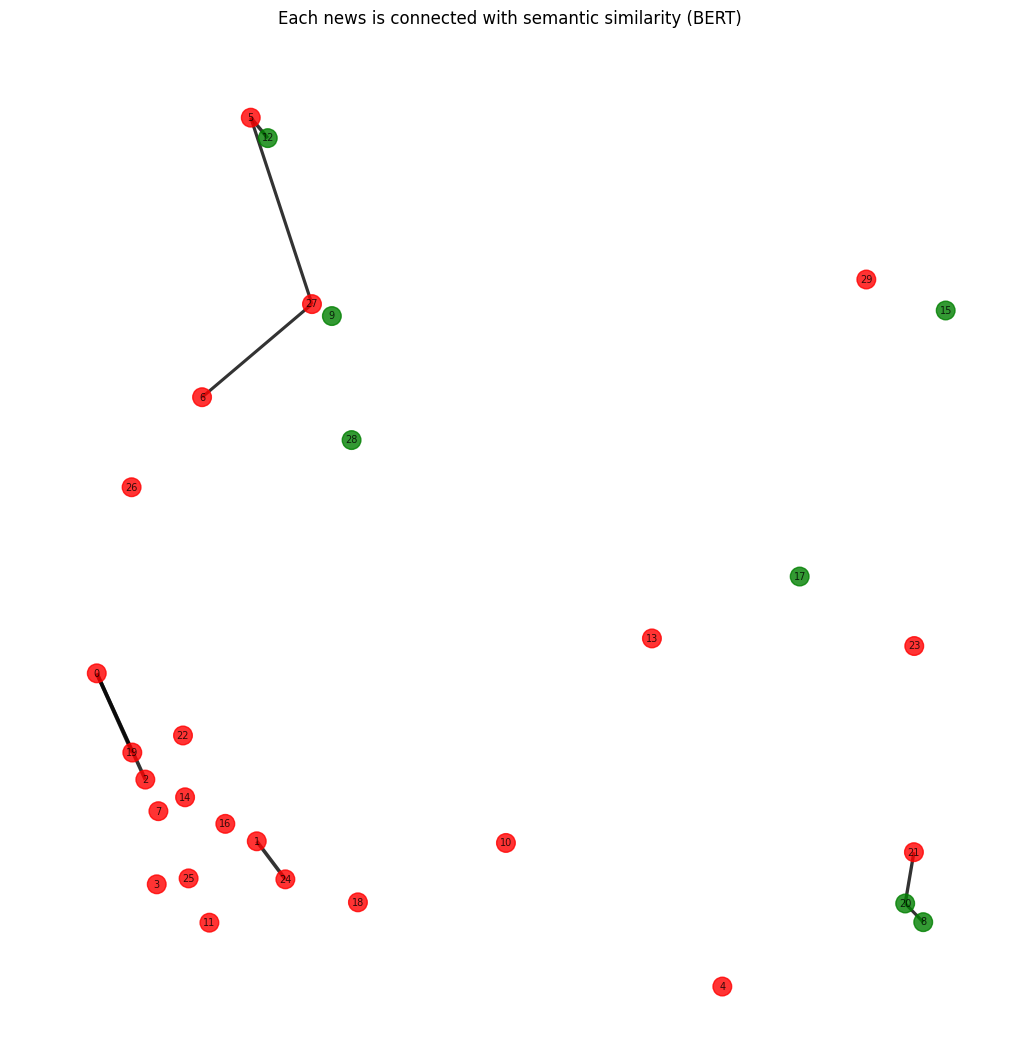

In [ ]:
#--- Visualize Subgraph ---
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# สมมติ plot 30 node แรก
subset_idx = np.arange(30)

subset_idx_set = set(subset_idx)
sub_edges = []
sub_weights = []
for i in range(edge_index_np.shape[1]):
    src, dst = edge_index_np[0, i], edge_index_np[1, i]
    if src in subset_idx_set and dst in subset_idx_set:
        sub_edges.append((src, dst))
        sub_weights.append(edge_weight_np[i])

G = nx.Graph()
G.add_nodes_from(subset_idx)  # เพื่อกัน node ที่ไม่มี edge หายไป
G.add_edges_from([(u, v, {"weight": float(w)}) for (u, v), w in zip(sub_edges, sub_weights)])

# PCA positions
node_emb = x_np[subset_idx]
pca = PCA(n_components=2)
node_pos_np = pca.fit_transform(node_emb)
node_pos = {idx: node_pos_np[i] for i, idx in enumerate(subset_idx)}

labels_now = df.iloc[subset_idx]['label'].values
color_map = ['red' if l=='ข่าวปลอม' else 'green' for l in labels_now]

print(f"node_pos: {len(node_pos)}, color_map: {len(color_map)}, G.nodes: {len(G.nodes())}")

plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos=node_pos,
    node_color=color_map,
    with_labels=True,
    node_size=180,
    alpha=0.8,
    width=[G[u][v]['weight']*3 for u,v in G.edges()],
    font_size=7
)
plt.title("Each news is connected with semantic similarity (BERT)")
plt.show()

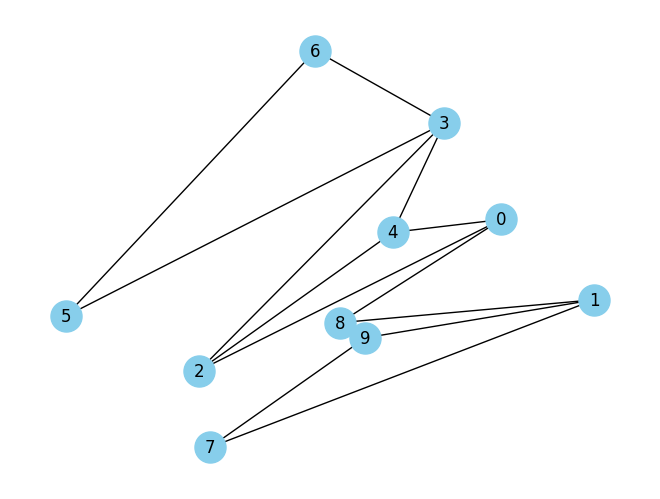

In [ ]:
#--- ตัวอย่างการสร้างกราฟ kNN ง่ายๆ ---
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (สมมติแทน BERT embedding 2 มิติ)
X = np.random.rand(10, 2)

# สร้าง kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# วาดกราฟ
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=500)
plt.show()


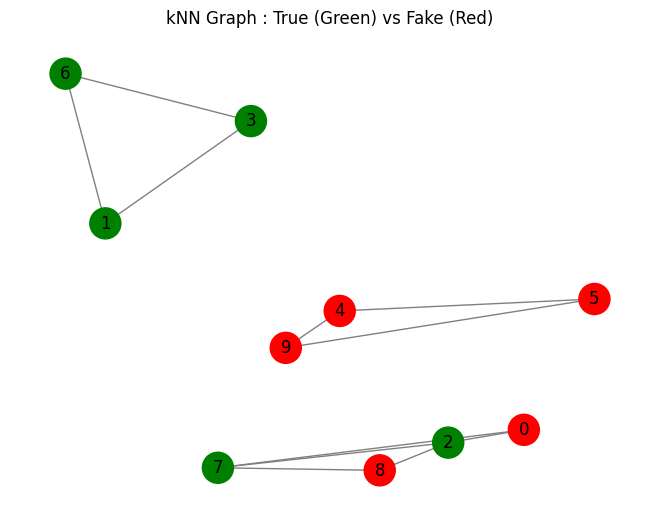

In [ ]:
#--- ตัวอย่างการสร้างกราฟ kNN พร้อมสีโหนดจาก label ---
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (แทน BERT embedding 2 มิติ)
X = np.random.rand(10, 2)

# label ของโหนด (0=ข่าวปลอม, 1=ข่าวจริง)
y = np.random.randint(0, 2, size=10)

# สร้าง kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# สร้างกราฟ
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

# map label → สี
color_map = ["red" if label == 0 else "green" for label in y]

# วาดกราฟ
pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=500, edge_color="gray")
plt.title("kNN Graph : True (Green) vs Fake (Red)")
plt.show()


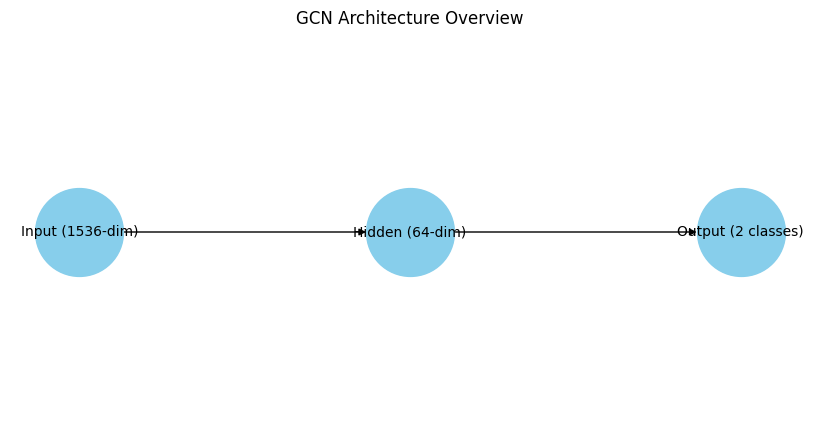

In [ ]:
# ----- วาดโครงสร้าง GCN -----
G = nx.DiGraph()

# Layer nodes
layers = {
    "Input (1536-dim)": (0, 2),
    "Hidden (64-dim)": (1, 2),
    "Output (2 classes)": (2, 2)
}

# เพิ่มโหนด
for layer, pos in layers.items():
    G.add_node(layer, pos=pos)

# เพิ่ม edge
G.add_edge("Input (1536-dim)", "Hidden (64-dim)")
G.add_edge("Hidden (64-dim)", "Output (2 classes)")

# วาด
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(8,4))
nx.draw(G, pos, with_labels=True, node_size=4000, 
        node_color="skyblue", font_size=10, arrows=True)
plt.title("GCN Architecture Overview")
plt.show()


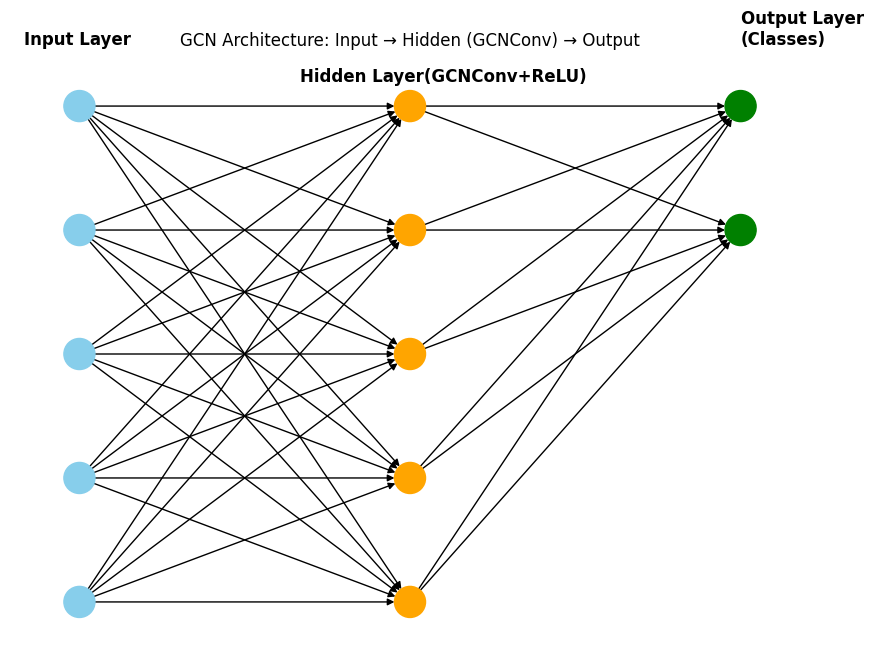

In [ ]:
#----- วาดโครงสร้าง GCN แบบละเอียด -----
import matplotlib.pyplot as plt
import networkx as nx

# สร้างโครงสร้าง GCN: Input Layer → Hidden Layer → Output Layer
G = nx.DiGraph()

layers = {
    "Input (Node Features)": range(5),      # ตัวอย่างมี 5 nodes input
    "Hidden (GCNConv + ReLU)": range(5, 10),
    "Output (Node Classes)": range(10, 12)  # 2 classes: Real/Fake
}

# เพิ่ม node
for layer, nodes in layers.items():
    for node in nodes:
        G.add_node(node, layer=layer)

# เชื่อม edge แบบ fully-connected ระหว่างแต่ละชั้น
for i in layers["Input (Node Features)"]:
    for j in layers["Hidden (GCNConv + ReLU)"]:
        G.add_edge(i, j)
for i in layers["Hidden (GCNConv + ReLU)"]:
    for j in layers["Output (Node Classes)"]:
        G.add_edge(i, j)

# จัดตำแหน่ง node แยกเป็น layers
pos = {}
x_gap = 3
for i, (layer, nodes) in enumerate(layers.items()):
    for j, node in enumerate(nodes):
        pos[node] = (i * x_gap, -j)

# map สี
color_map = []
for node in G.nodes():
    if node < 5:
        color_map.append("skyblue")  # input
    elif node < 10:
        color_map.append("orange")   # hidden
    else:
        color_map.append("green")    # output

# วาดกราฟ
plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=False, node_color=color_map, node_size=500, arrows=True)

# เพิ่ม label ชื่อ layer (ใช้ตำแหน่งเฉพาะ)
plt.text(-0.5, 0.5, "Input Layer", fontsize=12, fontweight="bold")
plt.text(2, 0.2, "Hidden Layer(GCNConv+ReLU)", fontsize=12, fontweight="bold")
plt.text(6, 0.5, "Output Layer\n(Classes)", fontsize=12, fontweight="bold")

plt.title("GCN Architecture: Input → Hidden (GCNConv) → Output")
plt.axis("off")
plt.show()




--- Visualization (t-SNE & PCA) ---
Using default SEED=42
Fitting t-SNE...


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifake

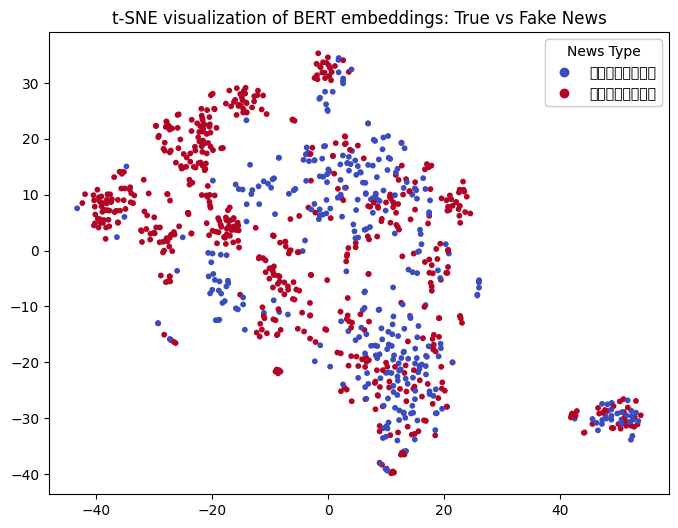

Fitting PCA...
PCA Explained Variance Ratio: Comp1=0.1628, Comp2=0.0595


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifake

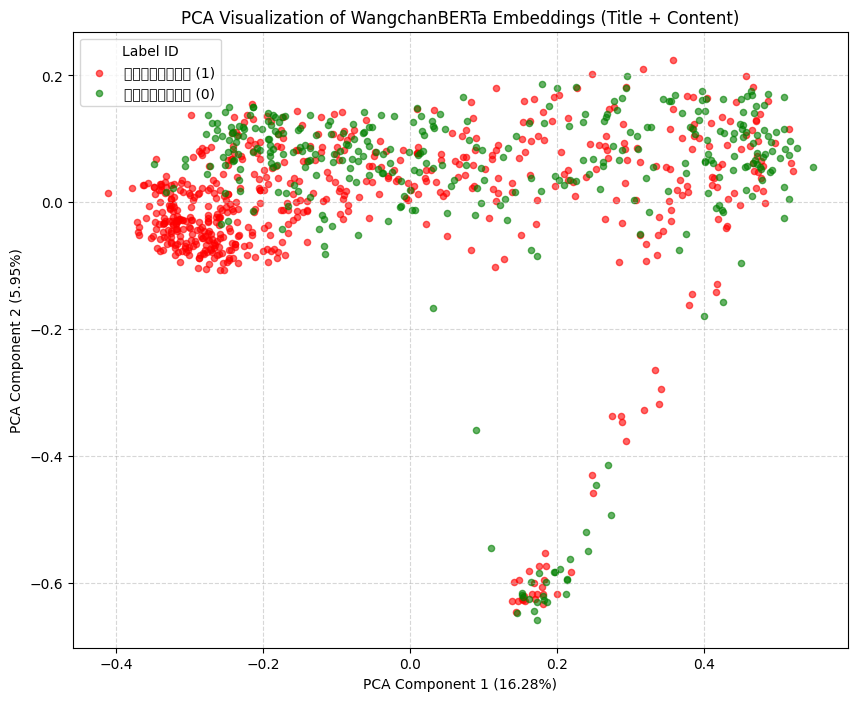

In [ ]:
# --------------------------------------------------------------------
# Visualization (t-SNE & PCA) 
# --------------------------------------------------------------------
print("\n--- Visualization (t-SNE & PCA) ---")

# กำหนด SEED 
try:
    SEED
except NameError:
    SEED = 42
    print(f"Using default SEED={SEED}")

try: 
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
    print("Fitting t-SNE...")
    x_2d_tsne = tsne.fit_transform(x_np)
    
    plt.figure(figsize=(8, 6))
    # ใช้ y_np ที่เป็นตัวเลขแล้วในการระบายสี
    scatter = plt.scatter(x_2d_tsne[:, 0], x_2d_tsne[:, 1], c=y_np, cmap='coolwarm', s=10)
    plt.title("t-SNE visualization of BERT embeddings: True vs Fake News")
    
    # เพิ่ม คำอธิบายสี ใช้ชื่อ Label จาก label2id

    classes = list(label2id.keys())
    # สร้าง handle สำหรับ legend
    legend1 = plt.legend(
        handles=scatter.legend_elements()[0], 
        labels=classes, 
        title="News Type"
    )
    plt.gca().add_artist(legend1)

    plt.show()
except Exception as e: 
    print(f"t-SNE plot skipped: {e}")

try:
    # PCA
   
    pca = PCA(n_components=2, random_state=42)
    print("Fitting PCA...")
    x_2d_pca = pca.fit_transform(x_np)
    
    # ตรวจสอบให้แน่ใจว่า 'ข่าวปลอม' และ 'ข่าวจริง' มีใน label2id
    fake_id = label2id.get('ข่าวปลอม', -1)
    real_id = label2id.get('ข่าวจริง', -2)
    
    fake_mask = (y_np == fake_id)
    real_mask = (y_np == real_id)

    plt.figure(figsize=(10, 8))
    
    # พล็อตกราฟสำหรับข่าวปลอม
    if fake_id != -1:
        plt.scatter(x_2d_pca[fake_mask, 0], x_2d_pca[fake_mask, 1],
                    color='red', alpha=0.6, s=20, label=f'fake ({fake_id})')
    
    # พล็อตกราฟสำหรับข่าวจริง
    if real_id != -2:
        plt.scatter(x_2d_pca[real_mask, 0], x_2d_pca[real_mask, 1],
                    color='green', alpha=0.6, s=20, label=f'true ({real_id})')
                    
    plt.title("PCA Visualization of WangchanBERTa Embeddings (Title + Content)")
    plt.xlabel(f"PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
    
    # แสดงค่า explained_variance_ratio
    print(f"PCA Explained Variance Ratio: Comp1={pca.explained_variance_ratio_[0]:.4f}, Comp2={pca.explained_variance_ratio_[1]:.4f}")

    plt.legend(title="Label ID")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
except Exception as e:
    print(f"PCA plot skipped: {e}")